In [20]:
import matplotlib
%matplotlib inline

# core libs
import os
import itertools
from collections import defaultdict, OrderedDict
import json
import yaml
import codecs
import re
from operator import itemgetter
import cPickle as pickle

from functools import wraps
from unidecode import unidecode

# numerical and ml libs
import numpy as np
from scipy.sparse import coo_matrix, hstack, csr_matrix
from nltk.corpus import wordnet as wn
import spacy
import sklearn
print("using sklearn version -> %s" % sklearn.__version__)
from sklearn.metrics import f1_score, confusion_matrix
from sklearn import linear_model, datasets, svm, ensemble
from sklearn.utils.extmath import safe_sparse_dot
import matplotlib.pyplot as plt

# project files
from dfiner.ontonote.ontonotes_data import load_ontonotes, read_figer, GoldMentionView

from dfiner.utils import get_default_config, get_size, dump_pickle, load_pickle
from dfiner.datastructures.utils import print_view
from dfiner.annotators.hyp_pattern_annotator import HypPatternAnnotator
from dfiner.annotators.kb_bias_annotator import KBBiasTypeAnnotator
from dfiner.annotators.nsd_annotator import NSDView
from dfiner.annotators.fine_type_annotator import FineTypeView, SynsetFineTyper
from dfiner.annotators import get_non_default_annotator
import dfiner.ontonotes_annotation_extender as oae
from dfiner.topics import get_embedding_func, EmbeddingsType
from dfiner.classifier.lexicon import Lexicon
from dfiner.classifier.feature_function import DenseFeatureFunction, FeatureExtractor, FeatureFunction, FeatureStroage

import fastFM

FeatureStroage.set_cache_dir("/home/haowu4/.py_cache")


using sklearn version -> 0.18.1


In [24]:
%%time
config = get_default_config()
nlp = spacy.load('en')

CPU times: user 12.8 s, sys: 3.61 s, total: 16.4 s
Wall time: 3min 55s


In [25]:
%%time
train_docs = load_ontonotes(nlp, config['ontonotes_train_and_dev_path'])
test_docs = load_ontonotes(nlp, config['ontonotes_test_path'])
figer_docs = read_figer(nlp, config['figer_path'])
figer_gold_docs = read_figer(nlp, config['figer_gold'])

IOError: [Errno 2] No such file or directory: '/save/muddire2/projects/figer/aaai/exp.label'

In [ ]:
def annotate_extend(docs):
    _ = [oae.add_titles(doc, oae.title_set) for doc in docs]
    _ = [oae.add_typexs('MEDICINE', doc, oae.symptom_alias_set.union(oae.drug_set.union(oae.treatment_set))) for doc in docs]
    _ = [oae.add_typexs('ANIMAL', doc, oae.animal_set) for doc in docs]
    _ = [oae.add_typexs('ROAD', doc, oae.road_set) for doc in docs]
    _ = [oae.fix_type1_to_type2(doc, "ORG", "FAC", oae.facility_as_org_trigger_words) for doc in docs]
    _ = [oae.fix_type1_to_type2(doc, "FAC", "ROAD", oae.road_set) for doc in docs]

In [ ]:
%%time
annotate_extend(train_docs)
annotate_extend(test_docs)

In [ ]:
print "loaded %d train docs" % len(train_docs)
print "loaded %d test docs" % len(test_docs)
print "loaded %d figer docs" % len(figer_docs)
print "loaded %d figer gold docs" % len(figer_gold_docs)

In [ ]:
kba = KBBiasTypeAnnotator(config)
hyp_pattern_annotator = HypPatternAnnotator(nlp)

In [ ]:
%%time
non_default_annotators = get_non_default_annotator(nlp, config)
# noun_and_rule_annotators = non_default_annotators[1:]

In [ ]:
non_default_annotators

In [ ]:
%%time
# %%prun -s cumulative
_ = [annotator(doc) for doc in train_docs for annotator in non_default_annotators[:2]]
_ = [annotator(doc) for doc in test_docs for annotator in non_default_annotators[:2]]
_ = [annotator(doc) for doc in figer_docs for annotator in non_default_annotators[:2]]
_ = [annotator(doc) for doc in figer_gold_docs for annotator in non_default_annotators[:2]]

In [ ]:
with open(config["ontonote_to_figer_map"]) as f_in:
    ontonotes_to_figer_course = yaml.load(f_in)

def type_func(mention_constituent):
    return ontonotes_to_figer_course[mention_constituent.name]

In [ ]:
def slash_to_dot(slash_str):
    return ".".join(slash_str.split("/")[1:])

def get_figer_type_func(kba):
    def figer_type_func(mention_constituent):
        all_types = map(slash_to_dot, mention_constituent.name.split(","))
        try:
            course_types = list(set(map(kba.type_system.get_root, all_types)))
            if len(course_types) > 1:
                print "CAUTION: more than one course types -> (%s). Assigining (%s)." % (course_types, course_types[0])
                return course_types[0]
            return course_types[0]
        except:
            print "CAUTION: encoutered error while looking up (%s)" % (all_types)
            return None
    return figer_type_func

figer_type_func = get_figer_type_func(kba)

In [ ]:
%%time
# we want full w2v
w2v_500k_pickle_path = "/save/muddire2/GoogleNews-vectors-negative300.combined_500k.pkl"
with open(w2v_500k_pickle_path) as f_in:
    w2vdict = pickle.load(f_in)

In [ ]:
default_w2v_mean = np.mean(list(w2vdict.values()), axis=0)
default_w2v_zero = np.zeros(default_w2v_mean.shape)

In [ ]:
# extended w2v with lowercase letters
extended_w2vdict = {}
for w in w2vdict:
    extended_w2vdict[w] = w2vdict[w]
    if w.lower() not in w2vdict:
        extended_w2vdict[w.lower()] = w2vdict[w]

print "# words in extended_w2vdict = %d" % len(extended_w2vdict)

In [ ]:
lsi_embedding_func = get_embedding_func(config, EmbeddingsType.LSI, 100)
lda_embedding_func = get_embedding_func(config, EmbeddingsType.LDA, 50)

In [ ]:
lsi_embedding_func()

In [ ]:
def word_shape_func(text):
    text = re.sub("[a-z]+", "a" ,text)
    text = re.sub("[A-Z]+", "A" ,text)
    text = re.sub("[0-9]+", "0" ,text)
    return text



def ngram_before(n):
    @FeatureFunction("%dgram_before" % n)
    def f(doc, mention):
        start, end = mention.start, mention.end
        if start - n >= 0:
            return [doc[start-n:start].text]
        else:
            return []
    f.__name__ = "%dgram_before" % n
    return f


def ngram_after(n):
    @FeatureFunction("%dgram_after" % n)
    def f(doc, mention):
        start, end = mention.start, mention.end
        if end + n <= len(doc):
            return [doc[end:end+n].text]
        else:
            return []
    f.__name__ = "%dgram_after" % n
    return f


@FeatureFunction("dep_feature")
def mention_details(doc, mention):
    start, end = mention.start, mention.end
    heads = [token.head for token in doc[start:end]]
    deps = [list(token.children) for token in doc[start:end]]
    for token, head, children in zip(doc[start:end], heads, deps):
        if not (head.i >= start and head.i < end):            
            yield "<-%s- %s" % (token.dep_, head.lemma_)
            yield "<- %s" % (head.lemma_)
        for child in children:
            if not (child.i >= start and child.i < end):
                yield  "-%s-> %s" % (child.dep_,child.lemma_)
                yield  "-> %s" % (child.lemma_)


@FeatureFunction("dep_feature_len2")
def dep_feat_len2(doc, mention):
    start, end = mention.start, mention.end
    heads = [token.head for token in doc[start:end]]
    deps = [list(token.children) for token in doc[start:end]]
    for token, head, children in zip(doc[start:end], heads, deps):
        # len 2 deps through head
        if head.head != head and not (start <= head.head.i < end):
            yield "<-%s- %s <-%s- %s" % (token.dep_, head.lemma_, head.dep_, head.head.lemma_)
            yield "<- %s <- %s" % (head.lemma_, head.head.lemma_)
        for child in head.children:
            if child == token or start <= child.i < end:
                continue
            yield "<-%s- %s -%s-> %s" % (token.dep_, head.lemma_, child.dep_, child.lemma_)
            yield "<- %s -> %s" % (head.lemma_, child.lemma_)
        # len 2 deps through children
        for child in children:
            for grandchild in child.children:
                if start <= grandchild.i < end:
                    continue
                yield  "-%s-> %s -%s-> %s" % (child.dep_, child.lemma_, grandchild.dep_, grandchild.lemma_)
                yield  "-> %s -> %s" % (child.lemma_, grandchild.lemma_)


def word_before(position):
    @FeatureFunction("word_before_%d" % position)
    def f(doc, mention):
        start, end = mention.start, mention.end
        for i in range(max(start-position,0), start):
            yield doc[i].text
    return f


def word_before_loc(position):
    @FeatureFunction("word_before_loc_%d" % position)
    def f(doc, mention):
        start, end = mention.start, mention.end
        for i in range(max(start-position,0), start):
            yield "%d-%s" % (start - i,doc[i].text)
    return f


def word_before_lemma(position):
    @FeatureFunction("word_before_lemma_%d" % position)
    def f(doc, mention):
        start, end = mention.start, mention.end
        for i in range(max(start-position,0), start):
            yield doc[i].lemma_
    return f


def word_after(position):
    @FeatureFunction("word_after_%d" % position)
    def f(doc, mention):
        start, end = mention.start, mention.end
        for i in range(end, min(end+position,len(doc))):
            yield doc[i].text
    return f


def word_after_loc(position):
    @FeatureFunction("word_after_loc_%d" % position)
    def f(doc, mention):
        start, end = mention.start, mention.end
        for i in range(end, min(end+position,len(doc))):
            yield "%d-%s" % (i - end,doc[i].text)
    return f


def word_after_lemma(position):
    @FeatureFunction("word_after_lemma_%d" % position)
    def f(doc, mention):
        start, end = mention.start, mention.end
        for i in range(end, min(end+position,len(doc))):
            yield doc[i].lemma_
        
    return f


@FeatureFunction("wim_shape")
def word_shape_in_mention(doc, mention):
    start, end = mention.start, mention.end
    for token in doc[start:end]:
        yield word_shape_func(token.text)


@FeatureFunction("wim")
def word_in_mention(doc, mention):
    start, end = mention.start, mention.end
    for token in doc[start:end]:
        yield token.text


@FeatureFunction("wim_lemma")
def word_in_mention_lemma(doc, mention):
    start, end = mention.start, mention.end
    for token in doc[start:end]:
        yield token.lemma_
        

@FeatureFunction("wim_loc")
def word_in_mention_loc(doc, mention):
    start, end = mention.start, mention.end
    for i,x in enumerate(doc[start:end]):
        yield "f%d-%s" % (i,x.text)
        yield "b%d-%s" % ((end-start-1) - i,x.text)
        

@FeatureFunction("wim_loc_lemma")
def word_in_mention_loc_lemma(doc, mention):
    start, end = mention.start, mention.end
    for i,x in enumerate(doc[start:end]):
        x = x.lemma_
        yield "f%d-%s" % (i,x)
        yield "b%d-%s" % ((end-start-1) - i,x)
    

def wim_ngram(n=2):
    @FeatureFunction("wim_%dgram" % n)
    def f(doc, mention):
        start, end = mention.start, mention.end
        words = map(lambda token: token.text, doc[start:end])
        for ngram_tup in zip(*[words[i:] for i in xrange(n)]):
            yield "-".join(ngram_tup)
    return f
        

def wim_ngram_lemma(n=2):
    @FeatureFunction("wim_%dgram_lemma" % n)
    def f(doc, mention):
        start, end = mention.start, mention.end
        words = map(lambda token: token.lemma_, doc[start:end])
        for ngram_tup in zip(*[words[i:] for i in xrange(n)]):
            yield "-".join(ngram_tup)
    return f


@FeatureFunction("mention_shape")
def mention_shape(doc, mention):
    start, end = mention.start, mention.end
    t = " ".join([x.text for x in doc[start:end]])
    return [word_shape_func(t)]
        

@FeatureFunction("mention_length")
def mention_length(doc, mention):
    start, end = mention.start, mention.end
    return ["%d" % (end-start)]
        

@FeatureFunction("prefix")
def prefix(doc, mention):
    start, end = mention.start, mention.end
    for w in doc[start:end]:
        for i in range(3, min(5, len(w.text))):
            yield w.text[:i]
        

@FeatureFunction("suffix")
def postfix(doc, mention):
    start, end = mention.start, mention.end
    for w in doc[start:end]:
        for i in range(3, min(5, len(w.text))):
            yield w.text[-i:]


# KB-Bias features
def kbbias(kbbias_annotator):
    @FeatureFunction("kbbias")
    def wrappee(doc, mention):
        surface = doc[mention.start:mention.end].text
        results = None
        if surface in kbbias_annotator.surface_to_type_dist:
            results = kbbias_annotator.surface_to_type_dist[surface]
        elif (surface[:4].lower() == 'the ') and \
              surface[4:] in kbbias_annotator.surface_to_type_dist:
            results = kbbias_annotator.surface_to_type_dist[surface[4:]]
        if results:
            return results.iteritems()
        else:
            return []
    return wrappee


def get_most_sim_from_gensim(gensim_w2v, query, topn):
    if query in gensim_w2v.cached_most_sim:
        return gensim_w2v.cached_most_sim[query]
    else:
        r = list(gensim_w2v.most_similar(query, topn=topn))
        gensim_w2v.cached_most_sim[query] = r
        return r

# KB-Bias features
def kbbias_approx(kbbias_annotator, gensim_word2vec, min_sim=0.5):
    @FeatureFunction("kbbias_approx")
    def wrappee(doc, mention):
        if mention.end - mention.start != 1:
            return []
        surface = doc[mention.start:mention.end].text
        results_dist = defaultdict(float)
        total_count = 0.0
        if surface not in gensim_word2vec.vocab:
            return []
        sims = get_most_sim_from_gensim(gensim_word2vec, surface, 4)
        for approx_word, sim_score in sims:
            results = None
            if sim_score < sim_score:
                continue
            if approx_word in kbbias_annotator.surface_to_type_dist:
                results = kbbias_annotator.surface_to_type_dist[approx_word]
            elif (approx_word[:4].lower() == 'the ') and \
                  approx_word[4:] in kbbias_annotator.surface_to_type_dist:
                results = kbbias_annotator.surface_to_type_dist[approx_word[4:]]
            if results:
                for k in results:
                    results_dist[k] += results[k]                   
                total_count += 1.0
        if total_count > 0:
            for k in results_dist:
                results_dist[k] = results_dist[k]   / total_count                 
            return results_dist.iteritems()
        else:
            return []
    
    return wrappee

@FeatureFunction("in_quotes")
def in_quotes(doc, mention):
    
    start, end = mention.start, mention.end
    
    if any([unidecode(doc[i].text) == '"' for i in xrange(max(0, start-2), start+1)]) and \
       any([unidecode(doc[i].text) == '"' for i in xrange(end-1, min(end+2, len(doc)))]):
            return ["in-double-quotes"]
    
    if any([unidecode(doc[i].text) == "'" for i in xrange(max(0, start-2), start+1)]) and \
       any([unidecode(doc[i].text) == "'" for i in xrange(end-1, min(end+2, len(doc)))]):
            return ["in-single-quotes"]
    
    return []


synset_typer = SynsetFineTyper(config)
take_best_sense = True


@FeatureFunction("hyp_fine_types")
def hyp_fine_type_feats(doc, mention):
    hyp_view = doc.user_data[HypPatternAnnotator.HYP_VIEW]
    nsd_view = doc.user_data[NSDView.NSD_VIEW_NAME]

    fine_type_scores = defaultdict(float)
    hyp_pattern_fine_type_scores = defaultdict(float)
    for token_constituent in hyp_view.constituents:
        # mention covers this token
        if mention.start <= token_constituent.start < mention.end:
            if token_constituent.incoming_relations is None:
                continue
            for relation in token_constituent.incoming_relations:
                # checking if source is inside the mention. could remove it too
                hypernym_token_constituent = relation.source
                if mention.start <= hypernym_token_constituent.start < mention.end:
                    continue
                # print doc[hypernym_token_constituent.start:hypernym_token_constituent.end]
                for nsd_constituent in nsd_view.constituents:
                    if nsd_constituent.start <= hypernym_token_constituent.start < nsd_constituent.end:
                        # print nsd_constituent.label2score
                        if take_best_sense:
                            synset_offset_pos, score = max(nsd_constituent.label2score.items(), key=itemgetter(1))
                            for fine_type in synset_typer.get_fine_types(synset_offset_pos):
                                fine_type_scores[fine_type] += 1.
                                hyp_pattern_fine_type_scores[relation.relation_name +"=>" + fine_type] += 1.
                        else:
                            for synset_offset_pos, score in nsd_constituent.label2score.iteritems():
                                for fine_type in synset_typer.get_fine_types(synset_offset_pos):
                                    # print fine_type
                                    fine_type_scores[fine_type] += score
                                    hyp_pattern_fine_type_scores[relation.relation_name +"=>" + fine_type] += score
    return fine_type_scores.items() + hyp_pattern_fine_type_scores.items()


@FeatureFunction("bias")
def CONSTANT_BIAS(doc, mention):
    start, end = mention.start, mention.end
    return ["bias"]

In [ ]:
def getOrDefault(m, k, d):
    if k in m:
        return m[k]
    else:
        return d


def topicSentence(sentEmbeddingFunc, feature_name, size):
    @DenseFeatureFunction(size)
    def topicSentence(doc, mention):
        tokenized_doc = [token.text for token in doc]
        return sentEmbeddingFunc(tokenized_doc)
    topicSentence.__name__ = feature_name
    return topicSentence

In [ ]:
len(lda_embedding_func("I am Pavan".split()))

In [ ]:
def get_ngrams_matches(token_sequence, ngram_set, max_n):
    """
    From the token_sequence return all ngrams of size <= max_n.
    Any ngram should be from the given ngram_set.
    Ensure all tokens in the token_sequence is part of one and exactly one ngram.
    """
    non_overlapping_matches = []
    l = len(token_sequence)
    max_n = min(l, max_n)
    for n in xrange(max_n, 0, -1):
        i = 0
        while i <= l-n:
            if any([(match[1][0]<=i<match[1][1] or match[1][0]<=i+n<match[1][1]) for match in non_overlapping_matches]):
                # overlapping with a higher ngram. skip.
                i += n
                continue
            s = "_".join(token_sequence[i:i+n])
            if s in ngram_set:
                non_overlapping_matches.append((s, (i, i+n)))
                i += n
                continue
            s_lower = s.lower()
            if s_lower in ngram_set:
                non_overlapping_matches.append((s_lower, (i, i+n)))
                i += n
                continue
            i += 1
    return non_overlapping_matches
                

def w2vMention(w2v_dict, default_w2v, max_n=3):
    @DenseFeatureFunction(300)
    def w2vMention(doc, mention):
        l = mention.end - mention.start
        if l == 0:
            print(doc)
            print("WARNING: The length of the mention is 0!")
        mention_tokens = [token.text for token in doc[mention.start:mention.end]]
        mean_vecs = [w2v_dict[match[0]] for match in get_ngrams_matches(mention_tokens, w2v_dict, max_n)]
        return np.mean(mean_vecs, axis=0) if len(mean_vecs) else default_w2v
    return w2vMention

In [ ]:
text = "The “ working ” German shepherds and Belgian malinois " + \
                 "he cared for were either attack dogs or bomb or narcotics sniffers "+ \
                 ", he said , standing in his year-old Baxter Creek Veterinary Clinic . "
token_sequence = text.decode('utf-8').split()

In [9]:
get_ngrams_matches(token_sequence, extended_w2vdict, 2)

NameError: name 'extended_w2vdict' is not defined

In [10]:
doc = figer_gold_docs[1]
print doc
print ""
hyp_view = doc.user_data[HypPatternAnnotator.HYP_VIEW]
nsd_view = doc.user_data[NSDView.NSD_VIEW_NAME]
print_view(doc, HypPatternAnnotator.HYP_VIEW)

NameError: name 'figer_gold_docs' is not defined

In [11]:
# features

# sparse feature functions

sparse_feat_funcs = [
#     CONSTANT_BIAS,
#     word_shape_in_mention,
#     word_in_mention, word_in_mention_lemma,

    mention_details,
    word_in_mention_loc, word_in_mention_loc_lemma,
    wim_ngram(2), wim_ngram_lemma(2),
    wim_ngram(3), wim_ngram(3),
    kbbias(kba), 
#     kbbias_approx(kba, gensim_word_vectors),
    hyp_fine_type_feats,
    in_quotes,
    ngram_before(3), #ngram_before(2),
    ngram_after(3), #ngram_after(2)
    dep_feat_len2,
        w2vMention(extended_w2vdict, default_w2v_mean, max_n=3),
#     topicSentence(lda_embedding_func,"lda_embedding",50),
    topicSentence(lsi_embedding_func,"lsi_embedding",100),
                    ]
#             wim_ext, wim_ext_lemma,   
#             word_shape,
#             mention_length,
#             prefix,
#             postfix,
#             mention_pronoun_wh_dep

NameError: name 'mention_details' is not defined

In [12]:

sparse_extractor = FeatureExtractor(sparse_feat_funcs)

NameError: name 'sparse_feat_funcs' is not defined

In [13]:
def build_corpora(docs, type_func, skip_none=True):
    ret = []
    for doc in docs:
        for m in doc.user_data["gold_mention_view"]:
            if skip_none and type_func(m) is None:
                continue
            ret.append((doc, m))
    return ret

def build_ys_from_gold(corpora, type_lex, type_func):
    ret = []
    missing = set()
    for doc, m in corpora:
        t = type_func(m)
        if t is None:
            raise ValueError("type is None")
        type_lex.see_lexeme(t)
        idx = type_lex.getOrNegOne(t)
        if idx == -1:
            missing.add(t)
        ret.append(idx)
    for t in missing:
        print("missing label %s" % t)
    return np.array(ret)

type_lex = Lexicon()
    
ontonote_train = build_corpora(train_docs, type_func)
Y_train = build_ys_from_gold(ontonote_train, type_lex, type_func)

ontonote_test = build_corpora(test_docs, type_func)
Y_test = build_ys_from_gold(ontonote_test, type_lex, type_func)

figer_test = build_corpora(figer_docs, figer_type_func)
Y_figer = build_ys_from_gold(figer_test, type_lex, figer_type_func)

figer_gold_test = build_corpora(figer_gold_docs, figer_type_func)
Y_figer_gold = build_ys_from_gold(figer_gold_test, type_lex, figer_type_func)

NameError: name 'train_docs' is not defined

In [14]:
# cache_dir = "/tmp/cache"

# if not os.path.isdir(cache_dir):
#     os.makedirs(cache_dir)

In [15]:
%%time
%%prun -s cumulative

force_update = True
min_support = 3
# sparse_extractor.build_lexicon(ontonote_train, min_support=min_support, force_update=force_update)
X_train = sparse_extractor.extract("ontonote-train", ontonote_train, force_update=force_update)
X_test = sparse_extractor.extract("ontonote-test", ontonote_test, force_update=force_update)
X_figer = sparse_extractor.extract("figer-test", figer_test, force_update=force_update)
X_figer_gold = sparse_extractor.extract("figer-gold-test", figer_gold_test, force_update=force_update)
feature_names = sparse_extractor.reverse_lexicon()

index_to_feat = {i:f for i, f in enumerate(feature_names)}
index_to_type = {i:t for t, i in type_lex.lexeme_to_index.iteritems()}

NameError: name 'sparse_extractor' is not defined

In [16]:
list(kbbias_approx(kba, gensim_word_vectors)(figer_docs[0], figer_docs[0].user_data["gold_mention_view"].constituents[1]))

NameError: name 'kbbias_approx' is not defined

In [17]:
figer_docs[0].user_data["gold_mention_view"].constituents[1].start

NameError: name 'figer_docs' is not defined

In [18]:
print X_train.shape
print X_test.shape
print X_figer.shape
print X_figer_gold.shape

NameError: name 'X_train' is not defined

# Eval Stuff

In [19]:
metric_names = ["micro-f1", "macro-f1", "weighted-f1"]
averages = ["micro", "macro", "weighted"]

def print_global_metrics_header(metric_names):
    print("%-15s %10s %10s %10s\n" % tuple(["dataset"] + metric_names))
    
def print_global_metrics(dataset_name, ys_gold, ys_pred, classes, averages):
    print("%-15s %9.2f%% %9.2f%% %9.2f%%" % tuple([dataset_name] + 
                                             [100*f1_score(ys_gold, ys_pred, classes, average=avg)
                                              for avg in averages]))

# Linear Classifier

In [ ]:
%%time

base_estimator = linear_model.SGDClassifier(
                    loss='hinge',#'modified_huber',#'hinge',#perceptron',
                    penalty="l1",
                    alpha=1e-4,
                    average=True,
#                     class_weight='balanced'
                    )
logreg = base_estimator
# logreg = ensemble.AdaBoostClassifier(n_estimators=50)

logreg.fit(X_train, Y_train)

In [483]:
y_train_pred = logreg.predict(X_train)
y_test_pred = logreg.predict(X_test)
y_figer_pred = logreg.predict(X_figer)
y_figer_gold_pred = logreg.predict(X_figer_gold)

classes = sorted(index_to_type.keys())

averages = ["micro", "macro", "weighted"]
print_global_metrics_header(metric_names)
print_global_metrics("train", Y_train, y_train_pred, classes, averages)
print_global_metrics("test", Y_test, y_test_pred, classes, averages)
print_global_metrics("figer", Y_figer, y_figer_pred, classes, averages)
print_global_metrics("figer-gold", Y_figer_gold, y_figer_gold_pred, classes, averages)
print("\n")

train_f1 = f1_score(Y_train, y_train_pred, classes, average=None).tolist()
test_f1 = f1_score(Y_test, y_test_pred, classes, average=None).tolist()
figer_gold_f1 = f1_score(Y_figer_gold, y_figer_gold_pred, classes, average=None).tolist()

class_names = [None] * len(index_to_type)
for i in range(len(index_to_type)):
    class_names[i] = index_to_type[i]

print("%22s : %8s %8s %8s\n" % ("TYPE", "train_f1", "test_f1", "figer_f1"))
for type_name, train_type_f1, test_type_f1, figer_gold_type_f1 in \
    sorted([(index_to_type[index], train_f1[index], test_f1[index], figer_gold_f1[index])
            for index in index_to_type], key=lambda a:a[2], reverse=True):
    print("%22s : %8.3f %8.3f %8.3f" % (type_name, train_type_f1, test_type_f1, figer_gold_type_f1)) 

dataset           micro-f1   macro-f1 weighted-f1

train               97.36%     88.24%     97.32%
test                94.42%     80.51%     94.21%
figer               83.24%     46.32%     82.55%
figer-gold          85.64%     52.40%     84.88%


                  TYPE : train_f1  test_f1 figer_f1

                 title :    0.997    0.997    0.917
      finance.currency :    0.996    0.990    0.000
                  time :    0.993    0.981    0.813
                 norpl :    0.976    0.967    0.952
              location :    0.979    0.957    0.859
          living_thing :    0.975    0.955    0.000
                person :    0.973    0.944    0.934
              medicine :    0.985    0.943    0.667
          organization :    0.962    0.925    0.838
   transportation.road :    0.953    0.846    0.400
                   law :    0.923    0.794    0.667
                 event :    0.914    0.677    0.167
               product :    0.810    0.660    0.000
                  work

In [484]:
# y_train_pred = logreg.predict(X_train)
# y_test_pred = logreg.predict(X_test)
# y_figer_pred = logreg.predict(X_figer)
# y_figer_gold_pred = logreg.predict(X_figer_gold)

# classes = sorted(index_to_type.keys())

# averages = ["micro", "macro", "weighted"]
# print("%-15s %10s %10s %10s\n" % ("dataset", "micro-f1", "macro-f1", "weighted-f1"))
# print("%-15s %9.2f%% %9.2f%% %9.2f%%" % tuple(["train"] + 
#                                              [100*f1_score(Y_train, y_train_pred, classes, average=avg)
#                                               for avg in averages]))
# print("%-15s %9.2f%% %9.2f%% %9.2f%%" % tuple(["test"] + 
#                                              [100*f1_score(Y_test, y_test_pred, classes, average=avg)
#                                               for avg in averages]))
# print("%-15s %9.2f%% %9.2f%% %9.2f%%" % tuple(["figer"] + 
#                                              [100*f1_score(Y_figer, y_figer_pred, classes, average=avg)
#                                               for avg in averages]))
# print("%-15s %9.2f%% %9.2f%% %9.2f%%" % tuple(["figer-gold"] + 
#                                              [100*f1_score(Y_figer_gold, y_figer_gold_pred, classes, average=avg)
#                                               for avg in averages]))
# print("\n")

# train_f1 = f1_score(Y_train, y_train_pred, classes, average=None).tolist()
# test_f1 = f1_score(Y_test, y_test_pred, classes, average=None).tolist()
# figer_gold_f1 = f1_score(Y_figer_gold, y_figer_gold_pred, classes, average=None).tolist()

# class_names = [None] * len(index_to_type)
# for i in range(len(index_to_type)):
#     class_names[i] = index_to_type[i]

# print("%22s : %8s %8s %8s\n" % ("TYPE", "train_f1", "test_f1", "figer_f1"))
# for type_name, train_type_f1, test_type_f1, figer_gold_type_f1 in \
#     sorted([(index_to_type[index], train_f1[index], test_f1[index], figer_gold_f1[index])
#             for index in index_to_type], key=lambda a:a[2], reverse=True):
#     print("%22s : %8.3f %8.3f %8.3f" % (type_name, train_type_f1, test_type_f1, figer_gold_type_f1)) 

# Creating Coarse Grain View, and annotating with fine-grain data

In [485]:
from dfiner.datastructures import View, Constituent
def add_pred_view(y_pred, docs_and_mentions, pred_viewname):
    for doc, _ in docs_and_mentions:
        if "OntonoteType" in doc.user_data:
            del doc.user_data['OntonoteType']

    assert len(y_pred) == len(docs_and_mentions)
    for pred, (doc, mention) in zip(y_pred, docs_and_mentions):
        user_data = doc.user_data
        if pred_viewname not in user_data:
            user_data[pred_viewname] = View()
        view = user_data[pred_viewname]
        label_name = type_lex.reverse_lex()[pred]
        c = Constituent(mention.start,
                        mention.end,
                        name=pred_viewname,
                        label2score={label_name: 1.0})
        view.add_constituent(c)
VIEW_NAME = "OntonoteType"
add_pred_view(y_figer_pred, figer_test, VIEW_NAME)
add_pred_view(y_figer_gold_pred, figer_gold_test, VIEW_NAME)


In [486]:
# from dfiner.utils import get_default_config
# from dfiner.ontonote.ontonotes_data import read_figer
# from dfiner.ontonote.mention_classifier import MentionClassifier
# from dfiner.ontonote.ontonote_annotator import OntonoteTypeAnnotator
# # from dfiner.annotators.mention_lex_entail import MentionEntailmentAnnotator
# # from dfiner.annotators.nsd_annotator import NounSenseAnnotator, AverageEmbeddingNSD

# # from dfiner.annotators.kb_bias_annotator import KBBiasTypeAnnotator
# # from dfiner.eval.utils import to_column_format
# import spacy
# import numpy as np
# import codecs
# import os

kbann = KBBiasTypeAnnotator(config, gensim_word_vectors, "OntonoteType")
config["kba"] = kbann
# mc = OntonoteTypeAnnotator(config)
# noun_sense = NounSenseAnnotator(config)

# nsd = None
# nsd_cache_path = config["nsd_cache_path"]
# embeddings_path = config["embeddings_path"]
# synset_offset_pos_embeddings_path = config["synset_offset_pos_embeddings_path"]
# if os.path.isfile(nsd_cache_path):
#     try:
#         nsd = AverageEmbeddingNSD.load_instance_from_pickle(nsd_cache_path)
#     except:
#         print("Encountered error while loading pickle from " + nsd_cache_path)
# nsd = nsd if nsd else AverageEmbeddingNSD(embeddings_path, synset_offset_pos_embeddings_path)
# nsd = NounSenseAnnotator(nsd)

# from dfiner.annotators import get_non_default_annotator
# non_default_annotators = get_non_default_annotator(nlp, config, ngram_length=3)

# mention_lex = MentionEntailmentAnnotator(config)
# mention_lex.mention_view ="OntonoteType"

In [487]:
from collections import defaultdict


def set_to_string(set_of_type):
    labels = ["/" + s.replace(".", "/") for s in set_of_type]
    return ",".join(sorted(labels))


def id(typs):
    return [x for source, x in typs]


def to_column_format(doc, use_views, type_map_function=id):
    ret = ""
    bios = defaultdict(lambda: "O")
    typs = defaultdict(set)
    for v, use_all in use_views:
        view = doc.user_data[v]
        for c in view.constituents:
            for i in range(c.start, c.end):
                if use_all and c.label2score:
                    for t in c.label2score:
                        typs[i].add((v, t))
                else:
                    # use best
                    if c.best_label_name:
                        typs[i].add((v, c.best_label_name))
                bios[i] = "I"
            bios[c.start] = "B"
    for i, token in enumerate(doc):
        w = token.text
        if bios[i] == "O":
            if len(typs[i]) == 0:
                inc = "%s\t%s\n" % (w, "O")
                ret += inc
            else:
                raise ValueError("O tag have types..")
        else:
            if len(typs[i]) > 0:
                types = type_map_function(typs[i])
                inc = "%s\t%s-%s\n" % (w, bios[i], set_to_string(types))
                ret += inc
            else:
                raise ValueError("B-I tag have no types..")
    return ret


In [488]:
def new_rule(typs):
    ret = []
    for source, x in typs:
        if source == "KBBiasType" and x == "organization.company":
#             pass
            continue
        if x == "norpl":
            x = "people.ethnicity"
        if x == "transportation.road":
            ret.append("location")
#         if x == "organization.sports_league":
#             ret.append("organization.company")
        if x == "news_agency":
            ret.append("organization.company")
        if x == "building":
            ret.append("location")
        ret.append(x)
    return set(ret)


VIEW_NAME = "OntonoteType"
add_pred_view(y_figer_pred, figer_test, VIEW_NAME)
add_pred_view(y_figer_gold_pred, figer_gold_test, VIEW_NAME)

def write_col_format_coarse(filename, figer_docs):
    counter = 0


    with codecs.open(filename, "w", "utf-8") as out:
        for doc in figer_docs:
            if "OntonoteType" not in doc.user_data:
                counter += 1
                doc.user_data["OntonoteType"] = View()
            for a in non_default_annotators:
                a(doc)
            use_types = [("OntonoteType", False)]
            for t, _ in use_types:
                if t not in doc.user_data:
                    doc.user_data[t] = View()
            s = to_column_format(doc, use_types)
    #         s = to_column_format(doc, [("OntonoteType", False)])        
            out.write(s)
            out.write("\n")
    print("%d doc do not have coarse grain new view... " % counter)
write_col_format_coarse("/home/haowu4/.py_cache/figer_docs_coarse.out", figer_docs)
# write_col_format("/tmp/figer_gold_docs.out", figer_gold_docs)


def write_col_format(filename, figer_docs):
    counter = 0

    with codecs.open(filename, "w", "utf-8") as out:
        for doc in figer_docs:
            if "OntonoteType" not in doc.user_data:
                counter += 1
                doc.user_data["OntonoteType"] = View()
            kbann(doc)
            meann(doc)
            for a in non_default_annotators:
                a(doc)
            use_types = [("OntonoteType", False), ("KBBiasType", False), ("MentionEntail", False)]
            for t, _ in use_types:
                if t not in doc.user_data:
                    doc.user_data[t] = View()
            s = to_column_format(doc, use_types, new_rule)
    #         s = to_column_format(doc, [("OntonoteType", False)])        
            out.write(s)
            out.write("\n")
    print("%d doc do not have coarse grain new view... " % counter)
write_col_format("/home/haowu4/.py_cache/figer_docs.out", figer_docs)
write_col_format("/home/haowu4/.py_cache/figer_gold_docs.out", figer_gold_docs)


def write_coarse_gold_col_format(filename, figer_docs):
    counter = 0
    for doc in figer_docs:
        gold_view = doc.user_data["gold_mention_view"]
        gold_coarse_view = View()
        for c in gold_view.constituents:
            label_name = figer_type_func(c)
            if label_name:
                cc = Constituent(c.start,
                            c.end,
                            name="gold_mention_coarse_view",
                            label2score={label_name: 1.0})
                gold_coarse_view.add_constituent(cc)
        doc.user_data["gold_mention_coarse_view"] = gold_coarse_view
        
        
    with codecs.open(filename, "w", "utf-8") as out:
        for doc in figer_docs:
            use_types = [("gold_mention_coarse_view", False)]
            for t, _ in use_types:
                if t not in doc.user_data:
                    doc.user_data[t] = View()
            s = to_column_format(doc, use_types)
    #         s = to_column_format(doc, [("OntonoteType", False)])        
            out.write(s)
            out.write("\n")
    print("%d doc do not have coarse grain new view... " % counter)

write_coarse_gold_col_format("/home/haowu4/.py_cache/figer_coarse_gold.out", figer_docs)
write_coarse_gold_col_format("/home/haowu4/.py_cache/figer_coarse_theirs.out", 
                             read_figer(nlp, "/home/muddire2/nlpresearch/datalessFNER/python/eval_output/example_output.figer_output")
)

# write_coarse_gold_col_format("/tmp/figer_coarse_gold.out", read_figer())

0 doc do not have coarse grain new view... 
Activivating for Friday, with confidence 0.84
defaultdict(<type 'float'>, {u'broadcast_program': 0.005434782608695652, u'written_work': 0.18478260869565216, u'music': 0.2391304347826087, u'art.film': 0.5706521739130435})
Activivating for Friday, with confidence 0.84
defaultdict(<type 'float'>, {u'broadcast_program': 0.005434782608695652, u'written_work': 0.18478260869565216, u'music': 0.2391304347826087, u'art.film': 0.5706521739130435})
Activivating for July, with confidence 0.91
defaultdict(<type 'float'>, {u'event.election': 1.0})
Activivating for December, with confidence 0.91
defaultdict(<type 'float'>, {u'event.natural_disaster': 0.058823529411764705, u'event.attack': 0.058823529411764705, u'event.protest': 0.029411764705882353, u'product.spacecraft': 0.029411764705882353, u'event.military_conflict': 0.058823529411764705, u'music': 0.5294117647058824, u'event.election': 0.23529411764705882})
Activivating for Friday, with confidence 0.84

In [489]:
for c in figer_docs[0].user_data["fine_type_view"].constituents:
    print c.start, c.end, c.label2score

23 24 {'medicine.symptom': 1.0, 'event': 1.0}
14 22 {'organization': 1.0, 'medicine.symptom': 1.0, 'event': 1.0, 'language': 1.0, 'person': 1.0}
5 10 {'person': 1.0, 'government.government': 1.0, 'education.department': 1.0, 'organization': 1.0}


In [67]:

[figer_type_func(c) for c in figer_docs[0].user_data["gold_mention_view"].constituents]

[u'organization', u'organization', 'organization', 'organization']

In [68]:
from dfiner.eval.eval import eval_two_file

eval_two_file(config["figer_path"], "/tmp/figer_docs.out")
print("----------------------------------------------------------------")
eval_two_file("//home/muddire2/nlpresearch/datalessFNER/python/eval_output/xiang_ren_figer_gold.label", "/tmp/figer_docs.out")
print("----------------------------------------------------------------")

eval_two_file(config['figer_gold'], "/tmp/figer_gold_docs.out")
print("----------------------------------------------------------------")
eval_two_file("/tmp/figer_coarse_gold.out", "/tmp/figer_coarse_theirs.out")

print("----------------------------------------------------------------")
eval_two_file("/tmp/figer_coarse_gold.out", "/tmp/figer_docs_coarse.out")



561
(324.0, 561.0, 561.0)
Strict F1 :
P: 0.578	 R: 0.578	 F1: 0.578



(533.0, 533.0, 674.0, 776.0)
Losse Mirco :
P: 0.791	 R: 0.687	 F1: 0.735



(454.0, 412.6666666666667, 561.0, 563.0)
Losse Marco F1 :
P: 0.809	 R: 0.733	 F1: 0.769
----------------------------------------------------------------
561
(330.0, 561.0, 561.0)
Strict F1 :
P: 0.588	 R: 0.588	 F1: 0.588



(557.0, 557.0, 674.0, 840.0)
Losse Mirco :
P: 0.826	 R: 0.663	 F1: 0.736



(473.0, 417.1333333333332, 561.0, 563.0)
Losse Marco F1 :
P: 0.843	 R: 0.741	 F1: 0.789
----------------------------------------------------------------
578
(365.0, 578.0, 578.0)
Strict F1 :
P: 0.631	 R: 0.631	 F1: 0.631



(579.0, 579.0, 690.0, 791.0)
Losse Mirco :
P: 0.839	 R: 0.732	 F1: 0.782



(493.0, 453.6666666666667, 578.0, 580.0)
Losse Marco F1 :
P: 0.853	 R: 0.782	 F1: 0.816
----------------------------------------------------------------
555
(445.0, 555.0, 555.0)
Strict F1 :
P: 0.802	 R: 0.802	 F1: 0.802



(445.0, 445.0, 555.0, 561.0)


In [ ]:
def print_performan_by_type(f1, f2):

    def is_B(line):
        line = line.strip().split()
        if len(line) != 2:
            return False
        return line[1].startswith("B-")

    def slash_to_dot(slash_str):
        return ".".join(slash_str.split("/")[1:])

    def extract_types(line):
        line = line.strip().split()
        if len(line) != 2:
            return set()
        typs = line[1].split("-")[1]
        return set(typs.split(","))


    pred_pairs = defaultdict(float)

    with open(f1) as gold_input:
        with open(f2) as pred_input:
            for gold_line, pred_line in zip(gold_input, pred_input):
                if is_B(gold_line):
                    if is_B(pred_line):
                        gold_type = extract_types(gold_line)
                        pred_type = extract_types(pred_line)
                        for g in gold_type:
                            for p in pred_type:
                                pred_pairs[(g, p)] += 1.0
                    else:
                        print("BB do not match...")

    gold_to_pred = defaultdict(lambda: defaultdict(float))
    pred_to_gold = defaultdict(lambda: defaultdict(float))

    gold_sum = defaultdict(float)
    pred_sum = defaultdict(float)

    all_type = set()

    for g, p in pred_pairs:
        c = pred_pairs[(g, p)]
        gold_to_pred[g][p] += c
        pred_to_gold[p][g] += c
        gold_sum[g] += c
        pred_sum[p] += c
        all_type.add(p)
        all_type.add(g)

    print("%40s\t%s\t%s\t%s\t%s\t%s" %
          ("label", "GC", "PC", "P", "R", "F1"))

    weight_sum = 0.0
    unweight_sum = 0.0
    N = 0.0
    
    for label in all_type:
        pc = pred_sum[label]
        gc = gold_sum[label]
        cc = pred_pairs[(label, label)]
        f1 = 0.0
        precision = 0.0
        recall = 0.0
        if cc == 0:
            pass
        else:
            if pc != 0:
                precision = cc / pc
            if gc != 0:
                recall = cc / gc
            f1 = 2 * precision * recall / (precision + recall)
            N += gc
            weight_sum += (f1 * gc)
            unweight_sum += f1

        print("%40s\t%d\t%d\t%.3f\t%.3f\t%.3f" %
              (slash_to_dot(label), int(gc), int(pc), precision, recall, f1))
        
    print("weight_sum = %.2f" % weight_sum)
    print("unweight_sum = %.2f" % unweight_sum)
    print("N = %.2f" % N)
    print("len(type) = %d" % len(gold_sum))
    s1 = set([slash_to_dot(x) for x in gold_sum])
    s2 = set(type_lex.reverse_lex())
    print(s1.difference(s2))
    print(s2.difference(s1))
    
print_performan_by_type(config["figer_path"], "/tmp/figer_docs.out")
print("----------------------------------------------------------------")
print_performan_by_type(config['figer_gold'], "/tmp/figer_gold_docs.out")
print("----------------------------------------------------------------")
print_performan_by_type("/tmp/figer_coarse_gold.out", "/tmp/figer_coarse_theirs.out")

In [ ]:
7.94/16.0

In [ ]:
444.81/548.00

# -----------------------------------------------------------------------------------------------------

In [265]:
# mistakes dictionary
mistake_dict = {}
correct_dict = {}
for i, (y_gold, y_pred) in enumerate(zip(Y_test, y_test_pred)):
    if y_gold != y_pred:
        mistake_dict.setdefault(y_gold, {})
        mistake_dict[y_gold].setdefault(y_pred, [])
        mistake_dict[y_gold][y_pred].append(i)
    else:
        correct_dict.setdefault(y_gold, [])
        correct_dict[y_gold].append(i)

In [266]:
# mistakes dictionary
figer_gold_mistake_dict = {}
figer_gold_correct_dict = {}
for i, (y_gold, y_pred) in enumerate(zip(Y_figer_gold, y_figer_gold_pred)):
    if y_gold != y_pred:
        figer_gold_mistake_dict.setdefault(y_gold, {})
        figer_gold_mistake_dict[y_gold].setdefault(y_pred, [])
        figer_gold_mistake_dict[y_gold][y_pred].append(i)
    else:
        figer_gold_correct_dict.setdefault(y_gold, [])
        figer_gold_correct_dict[y_gold].append(i)

In [260]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          annotate=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        orginal_cm = cm
        cm = cm.astype('float') / np.maximum(1, cm.sum(axis=1)[:, np.newaxis])
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
#     print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    if annotate:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



Confusion matrix, without normalization
Normalized confusion matrix


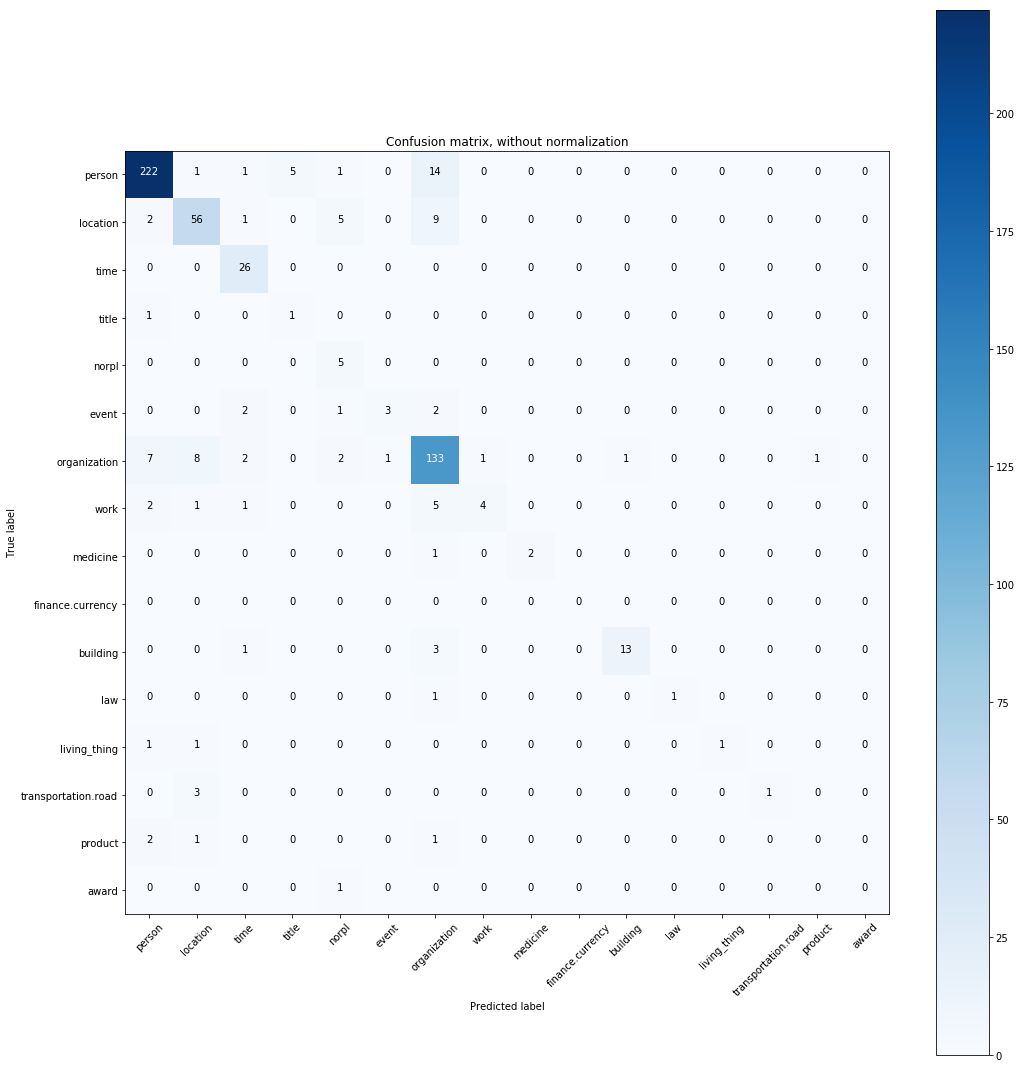

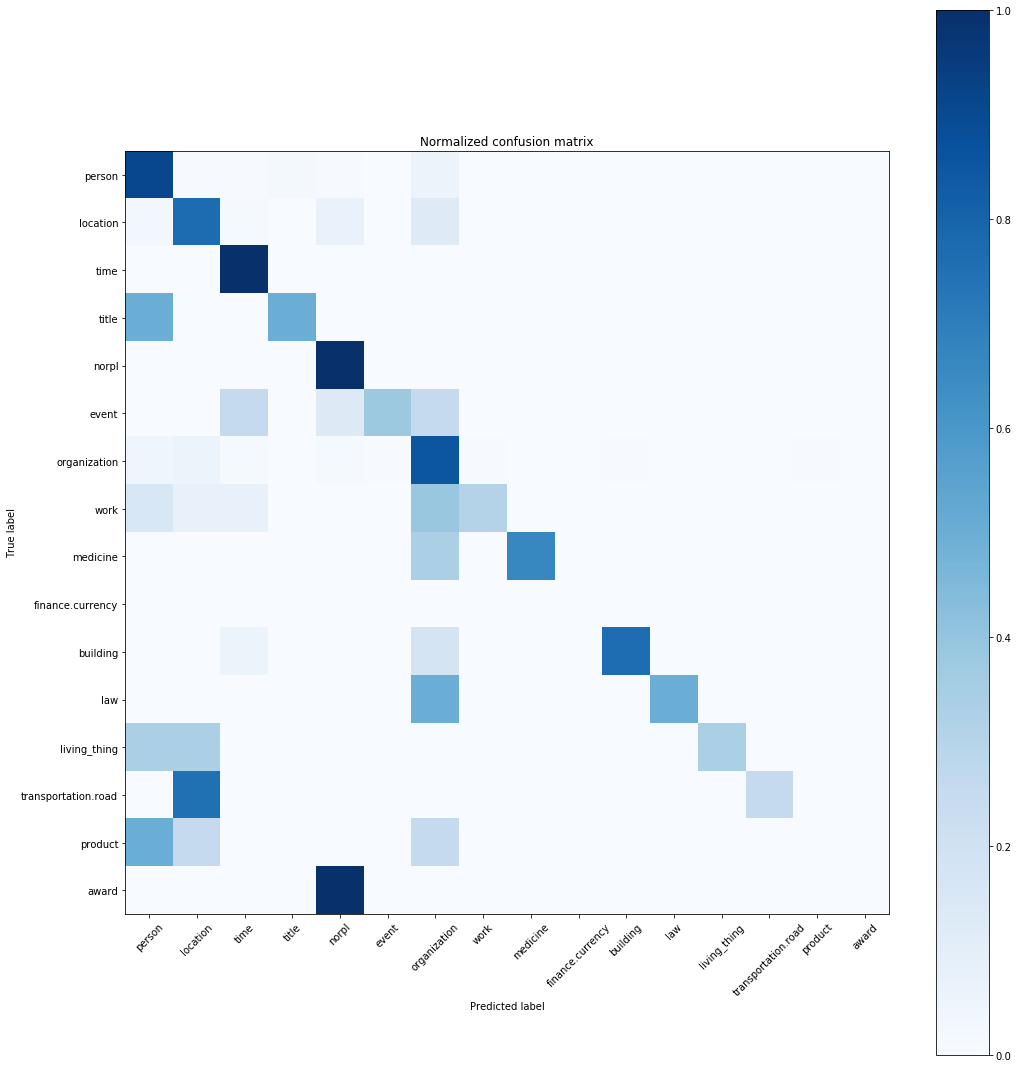

In [262]:

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_figer, y_figer_pred, classes)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15,15))
class_names = [index_to_type[k] for k in xrange(len(index_to_type))]
plot_confusion_matrix(cnf_matrix, classes=class_names, annotate=True,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Confusion matrix, without normalization
Normalized confusion matrix


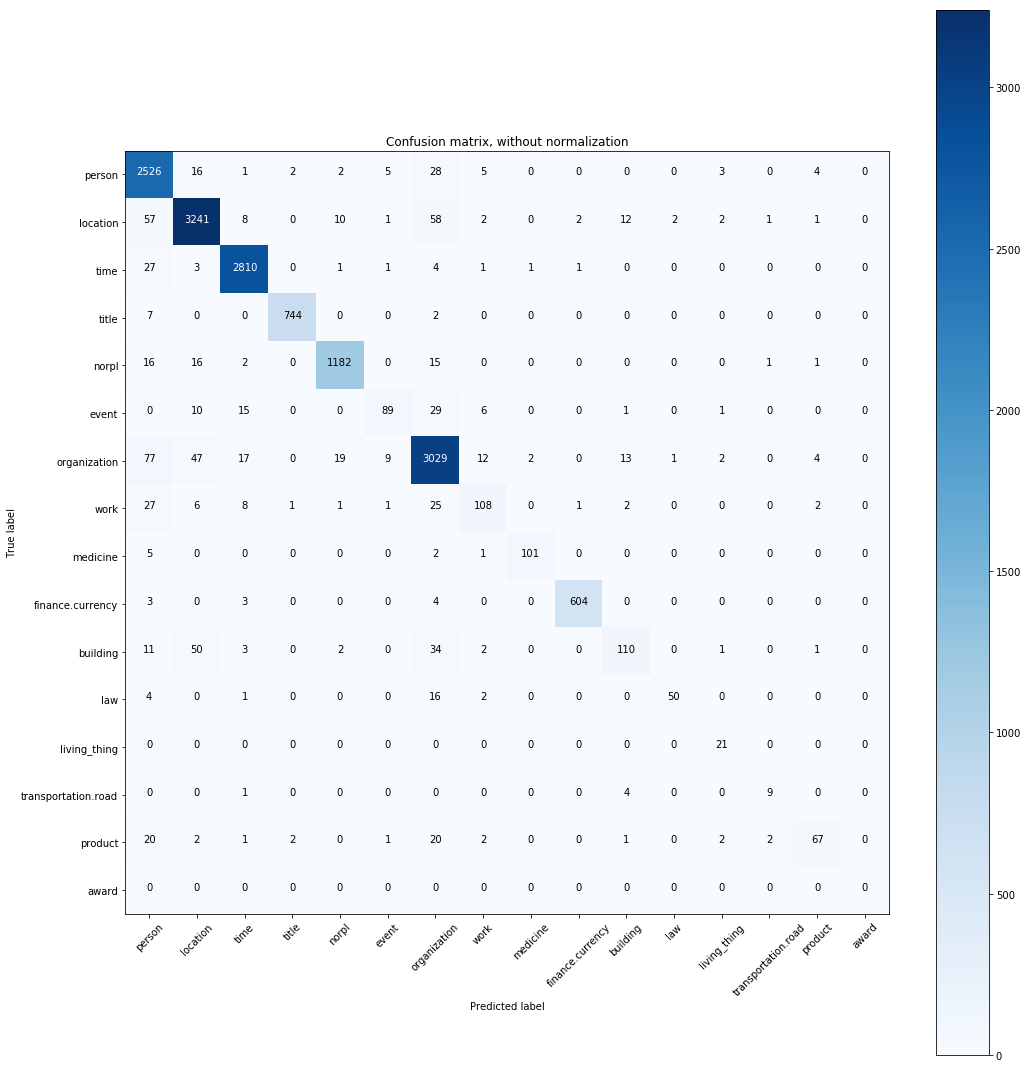

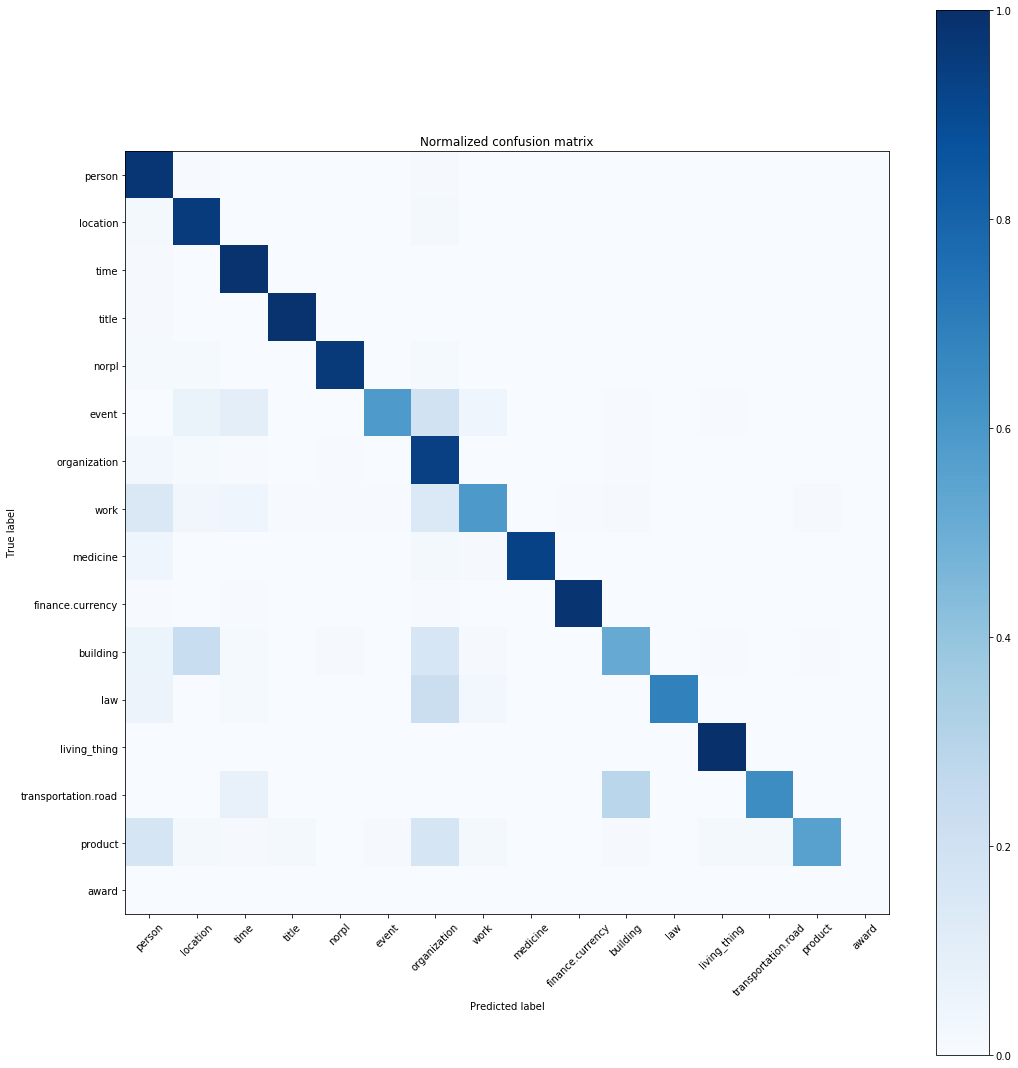

In [261]:

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test, y_test_pred, classes)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15,15))
class_names = [index_to_type[k] for k in xrange(len(index_to_type))]
plot_confusion_matrix(cnf_matrix, classes=class_names, annotate=True,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
set(Y_figer_gold)

In [ ]:
# # Compute confusion matrix
# figer_gold_cnf_matrix = confusion_matrix(Y_figer_gold, y_figer_gold_pred, classes)
# np.set_printoptions(precision=2)

# # Plot non-normalized confusion matrix
# plt.figure(figsize=(15,15))
# class_names = [index_to_type[k] for k in xrange(len(index_to_type))]
# plot_confusion_matrix(figer_gold_cnf_matrix, classes=class_names, annotate=True,
#                       title='Figer Gold Confusion matrix, without normalization')

# # Plot normalized confusion matrix
# plt.figure(figsize=(15,15))
# plot_confusion_matrix(figer_gold_cnf_matrix, classes=class_names, normalize=True,
#                       title='Figer Gold Normalized confusion matrix')

# plt.show()

In [263]:
def interpret_prediction(lin_classifier, doc, surface, x, y_gold, index_to_feat, index_to_type, dense_feat_names, 
                         num_dense, dense_dims, 
                         num_top_sparse_feats=5):
    # assumes all dense feats are at last
    
    num_dense_dims = sum(dense_dims)
    
    # shape (num_classes, num_feats)
    scores_matrix = x.toarray().flatten() * lin_classifier.coef_
    # get best axis ≠ y
    class_scores = np.sum(scores_matrix, axis=1) + lin_classifier.intercept_
    gold_not_given = False
    if y_gold == -1:
        print "CAUTION - gold label not provided! treating the best prediciton as gold.\n\n"
        gold_not_given = True
        y_gold = np.argmax(class_scores)
    y_gold_score = class_scores[y_gold]
    top_classes = list(np.argsort(-class_scores))
    gold_position = top_classes.index(y_gold) + 1
    y_hat = top_classes[1] if gold_position == 1 else top_classes[0]
    y_hat_score = class_scores[y_hat]
    
    def print_top_sparse_feats(sparse_feat_scores):
        top_sparse_indices = np.argsort(-np.abs(sparse_feat_scores))
        def print_scores(positive):
            count = num_top_sparse_feats
            i = 0
            while count > 0:
                feat_index = top_sparse_indices[i]
                feat = index_to_feat[feat_index]
                feat_score = sparse_feat_scores[feat_index]
                if (positive and feat_score > 0) or ((not positive) and feat_score < 0):
                    count -= 1
                    print "%-30s : %.3f" % (feat, feat_score)
                elif feat_score == 0:
                    break
                i += 1
        print "top +ve sparse feats:"
        print "-"*21 + "\n"
        print_scores(True)
        print ""
        print "top -ve sparse feats:"
        print "-"*21 + "\n"
        print_scores(False)
            
    
    def print_dense(dense_feat_scores):
        print "dense feats:"
        print "-"*12 + "\n"
        for name, score in zip(dense_feat_names, dense_feat_scores):
            print "%-30s : %.3f" % (name, score)
    
    print "sentence -> %s" % doc
    print "\n"
    print "mention -> \"%s\"" % surface
    print "\n"
    
    if not gold_not_given:
        print "%s prediction" % ("✔" if y_gold_score > y_hat_score else "✘")
        print "rank of gold = %d" % gold_position
        print "\n"
    
    print "gold class, \"%s\" score = %.3f" % (index_to_type[y_gold], y_gold_score)
    print "-"*38 + "\n"
    dense_scores = scores_matrix[y_gold][-num_dense_dims:]
    dense_feat_scores = []
    cur_index = 0
    for i in xrange(num_dense):
        dense_dim = dense_dims[i]
        dense_feat_scores.append( np.sum(dense_scores[cur_index:cur_index+dense_dim]) )
        cur_index += dense_dim
    print_dense(dense_feat_scores)
    print "\n"
    print_top_sparse_feats(scores_matrix[y_gold][:-num_dense_dims])
    print "\n"

    
    print "\n"
    

    print "pred (≠ gold) class, \"%s\" score = %.3f" % (index_to_type[y_hat], y_hat_score)
    print "-"*51 + "\n"
    dense_feat_scores = np.sum(np.reshape(scores_matrix[y_hat][-num_dense_dims:], (-1, dense_dim)), axis=1)
    print_dense(dense_feat_scores)
    print "\n"
    print_top_sparse_feats(scores_matrix[y_hat][:-num_dense_dims])
    print "\n"


In [ ]:
get_ngrams_matches("The Hundred Regiments Offensive".split(), extended_w2vdict, 3)

In [269]:
X_test_csc = X_test.tocsc()

In [270]:
debug_count = 0

In [ ]:
event_train_surfaces = set()
for doc, mention in ontonote_train:
    if mention.name == 'EVENT':
        event_train_surfaces.add(doc[mention.start:mention.end].text)
event_train_surfaces = list(event_train_surfaces)

In [ ]:
( event_train_surfaces )

In [271]:
# ontonotes test mistake analysis

gold_type, pred_type = "event", "organization"

try:
#     i = figer_gold_correct_dict[type_lex.lexeme_to_index[gold_type]][debug_count]
    i = mistake_dict[type_lex.lexeme_to_index[gold_type]][type_lex.lexeme_to_index[pred_type]][debug_count]
    doc, mention = ontonote_test[i]
    debug_count += 1
    interpret_prediction(logreg,
                     doc, doc[mention.start:mention.end],
                     X_test_csc[i], Y_test[i],
                     index_to_feat, index_to_type, ["w2v-mention", "topic-score"], 2, [300, 50],
#                      index_to_feat, index_to_type, ["w2v-mention"], 1, [300],
                     num_top_sparse_feats=10
                    )

except IndexError as e:
    print "exausted errors (%d). resetting debug_count to 0" % (debug_count)
    debug_count = 0



AttributeError: 'BaggingClassifier' object has no attribute 'coef_'

In [ ]:
debug_count = 0

In [272]:
# figer mistake analysis

# i = figer_gold_mistake_dict[type_lex.lexeme_to_index['work']][type_lex.lexeme_to_index['person']][debug_count]
# i = figer_gold_mistake_dict[type_lex.lexeme_to_index['organization']][type_lex.lexeme_to_index['location']][debug_count]
# i = figer_gold_mistake_dict[type_lex.lexeme_to_index['living_thing']][type_lex.lexeme_to_index['norpl']][debug_count]
# i = figer_gold_mistake_dict[type_lex.lexeme_to_index['work']][type_lex.lexeme_to_index['organization']][debug_count]
gold_type, pred_type = "person", "organization"
# gold_type, pred_type = "organization", "work"
# gold_type, pred_type = "event", "organization"
# gold_type, pred_type = "event", "medicine"
# gold_type, pred_type = "living_thing", "norpl"
# gold_type, pred_type = "living_thing", "location"
# gold_type, pred_type = "living_thing", "organization"
# gold_type, pred_type = "building", "organization"
# gold_type, pred_type = "product", "organization"
# gold_type, pred_type = "product", "finance.currency"
# gold_type, pred_type = "law", "organization"
# gold_type, pred_type = "work", "person"
# gold_type, pred_type = "work", "location"
# gold_type, pred_type = "work", "organization"
# gold_type, pred_type = "work", "norpl"
# gold_type, pred_type = "work", "building"
# gold_type, pred_type = "work", "product"
# gold_type, pred_type = "transportation.road", "location"
# gold_type, pred_type = "transportation.road", "building"

try:
#     i = figer_gold_correct_dict[type_lex.lexeme_to_index[gold_type]][debug_count]
    i = figer_gold_mistake_dict[type_lex.lexeme_to_index[gold_type]][type_lex.lexeme_to_index[pred_type]][debug_count]
    debug_count += 1
    interpret_prediction(logreg,
                     figer_gold_docs[figer_gold_doc_indices[i]], figer_gold_surfaces[i],
                     X_figer_gold[i], ys_figer_gold[i],
#                      index_to_feat, index_to_type, ["w2v-mention", "topic-score"], 2, [300, 50],
                     index_to_feat, index_to_type, ["w2v-mention"], 1, [300],
                     num_top_sparse_feats=10
                    )

except IndexError as e:
    print "exausted errors (%d). resetting debug_count to 0" % (debug_count)
    debug_count = 0



NameError: name 'figer_gold_doc_indices' is not defined

In [ ]:
print(1)

In [ ]:
doc = figer_gold_docs[figer_gold_doc_indices[i]]
print doc
print ""
print "hyp_view:\n"
print_view(doc, 'hyp_view')
print ""
print "mentions:\n"
print_view(doc, GoldMentionView.GOLD_MENTION_VIEW_NAME)

In [73]:
kbann.surface_to_type_dist["Wash"]

KeyError: 'Wash'

In [78]:
extended_w2vdict["Wash"]

array([ -2.16797000e-01,   3.49609000e-01,   1.55273000e-01,
         1.93359000e-01,  -1.36719000e-01,   2.61719000e-01,
        -3.61328000e-01,  -1.16699000e-01,   1.30859000e-01,
         2.28516000e-01,   5.51758000e-02,   5.61523000e-02,
         8.88672000e-02,   1.05469000e-01,   1.53198000e-02,
        -1.33789000e-01,  -3.18359000e-01,   3.02734000e-01,
         8.60596000e-03,   1.18164000e-01,  -5.34668000e-02,
         7.81250000e-02,  -1.09375000e-01,   2.04468000e-03,
        -9.91211000e-02,   3.20312000e-01,  -1.25000000e-01,
         2.51953000e-01,  -3.12500000e-02,  -6.64062000e-02,
        -1.50391000e-01,   1.66016000e-02,   2.10938000e-01,
        -2.67578000e-01,  -1.77734000e-01,  -4.05273000e-02,
        -7.42188000e-02,  -8.10547000e-02,  -3.12500000e-02,
         1.40625000e-01,  -7.86133000e-02,  -1.75781000e-01,
        -1.30859000e-01,   4.80957000e-02,  -1.79688000e-01,
        -8.44727000e-02,   1.02539000e-02,  -3.02734000e-01,
         3.45703000e-01,

In [98]:
from scipy import spatial

def nearset_word(query):
    query_w2v = extended_w2vdict[query]
    min_v = 99999
    min_w = query
    for w in extended_w2vdict:
        if w.lower() == query.lower():
            continue
        v = spatial.distance.cosine(query_w2v, extended_w2vdict[w])
        if v < min_v:
            min_v = v
            min_w = w
    return min_w, min_v


In [99]:
nearset_word("Wash.")

(u'ore.', 0.30273255631987039)

In [103]:
 spatial.distance.cosine([1,1],[1,1])

2.2204460492503131e-16

In [104]:
from gensim.models.keyedvectors import KeyedVectors
gensim_word_vectors = KeyedVectors.load_word2vec_format("/save/haowu4/GoogleNews-vectors-negative300.combined_500k.txt", binary=False)

'/save/muddire2/GoogleNews-vectors-negative300.combined_500k.txt'

In [133]:
gensim_word_vectors.most_similar("New York")

KeyError: "word 'New York' not in vocabulary"

In [273]:
gensim_word_vectors.most_similar_cosmul("Zarowsky")

KeyError: "word 'Zarowsky' not in vocabulary"

In [208]:
%%timeit

"A" in gensim_word_vectors

The slowest run took 16.49 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 434 ns per loop


In [224]:
len(extended_w2vdict)

804253

In [227]:
gensim_word_vectors.cached_most_sim = {}

In [348]:
kbann.surface_to_type_dist["NBA"]

{u'broadcast_program': 0.0017206521271561923,
 u'news_agency': 0.33268808878564976,
 u'organization.company': 0.3326450724824709,
 u'organization.sports_league': 0.33281713769518645,
 u'organization.sports_team': 4.30163031789048e-05,
 u'person.author': 8.60326063578096e-05}

In [393]:
from nltk.corpus import wordnet as wn
from dfiner.datastructures import View, Constituent
from dfiner.annotators.fine_type_annotator import SynsetFineTyper
from sklearn.metrics.pairwise import cosine_similarity

from dfiner.types.finer_type_system import FinerTypeSystem

from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))

def best_k_label(label2score, k):
    min_v = sorted(label2score.values(), reverse=True)[k-1]
    return [x for x in label2score if label2score[x] >= min_v]


def embedding_of_phrase(gensim_w2v, doc, start, end):
    base_vec = np.zeros(300)
    counter = 0.0
    for w in doc[start: end]:
        w = w.text
        if w.lower() in stopWords:
            continue            
        if w in gensim_w2v:
            b = gensim_w2v[w]
            base_vec += b
            counter += 1.0
    return base_vec


class MentionEntailmentAnnotator(object):
    TYPE_NAME = "MentionEntail"
    def __init__(self,
                 config,
                 gensim_w2v,
                 min_cosine=0.4,
                 mention_view ="OntonoteType"
                 ):
        self.typer = SynsetFineTyper(config)
        self.min_cosine = min_cosine
        self.gensim_w2v = gensim_w2v
        self.type_system = FinerTypeSystem.load_type_system(config)
        self.mention_view = mention_view

    def __call__(self, doc):
        new_view = View()
        view = doc.user_data[self.mention_view]
        for constituent in view.constituents:
            start = constituent.start
            end = constituent.end
            types = set()
            max_sim = defaultdict(float)
            mention_vec = embedding_of_phrase(self.gensim_w2v, doc, start, end)
            mention_vec = embedding_of_phrase(self.gensim_w2v, doc, 0, len(doc))

            for w in doc[max(start-1, 0): end]:
#                 print "Searching ... ", w
                for x in wn.synsets(w.text):
                    if x.pos() == "n":
                        def_doc = nlp.make_doc(x.definition())
                        def_vec = embedding_of_phrase(self.gensim_w2v, def_doc, 0, len(def_doc))
                        sim_score = cosine_similarity(def_vec.reshape(1,-1), mention_vec.reshape(1,-1))[0,0]                        
                        tps_w = self.typer.get_fine_types("%d_n" % x.offset())
                        for t in tps_w:
                            types.add(t)
                            max_sim[t] = max(max_sim[t], sim_score)
#                         print(x)
#                         print(x.definition())
#                         print(sim_score)
#                         print(types)
#                         print(" ")
            if len(constituent.label2score) == 0:
                continue
                
#             kk = max(self.trust_k, len(constituent.label2score))
#             print(kk)
#             ls = set(best_k_label(constituent.label2score, kk))

#             print("111",ls)
            ls = constituent.label2score.keys()
            mx_label2score = {}
#             print("\n"*3)
#             print("Fine types", types)
#             print("Coarse types", ls)
            for fine_type in types:
                for coarse_type in ls:
                    try:
#                         print("Checking [%s],[%s]" % (fine_type, coarse_type) )
                        check = self.type_system.a_belongs_to_b(fine_type, coarse_type)
#                         print check
                        if check:
#                             print("!!! Checking %s,%s" % (fine_type, coarse_type) )
                            if max_sim[fine_type] > self.min_cosine:
                                mx_label2score[fine_type] = max_sim[fine_type] 
                    except KeyError:
                        print("Not found type %s or %s" % (coarse_type, fine_type))
                        continue
#             print(mx_label2score)
            if len(mx_label2score) > 0:
                c = Constituent(start,
                                end,
                                self.TYPE_NAME,
                                label2score=mx_label2score)
                new_view.add_constituent(c)
        doc.user_data[self.TYPE_NAME] = new_view

meann = MentionEntailmentAnnotator(config, gensim_word_vectors)

In [367]:
kbann

In [379]:
gensim_word_vectors.most_similar("Cougars")

[(u'Mustangs', 0.8690695762634277),
 (u'Wildcats', 0.8429080247879028),
 (u'Spartans', 0.8191928863525391),
 (u'Bulldogs', 0.8123408555984497),
 (u'Lancers', 0.811346173286438),
 (u'T_Birds', 0.8102020025253296),
 (u'Golden_Bears', 0.8078759908676147),
 (u'Bearcats', 0.8033010959625244),
 (u'Yellowjackets', 0.798908531665802),
 (u'Marauders', 0.7931555509567261)]

In [438]:
kbann.surface_to_type_dist[u'AAAS']

{u'organization.company': 1.0}

In [446]:
import codecs
import gzip
import json
from dfiner.datastructures import View, Constituent
from dfiner.types.finer_type_system import FinerTypeSystem


class KBBiasTypeAnnotator(object):

    TYPE_NAME = "KBBiasType"

    @staticmethod
    def load_surface_to_typedist(fname):
        ret = {}
        with gzip.open(fname, 'rb') as zf:
            reader = codecs.getreader("utf-8")
            contents = reader(zf)
            for line in contents:
                obj = json.loads(line)
                ret[obj['surface']] = obj["type_dist"]
        return ret

    def __init__(self,
                 config,
                 gensim_w2v = None,
                 mention_view="OntonoteType"):
        # surface_to_type_dist maps
        #       (surface, coarse type) => fine type to fine type.
        self.surface_to_type_dist = self.load_surface_to_typedist(
            config["mention_to_type_dist"])
        self.coarse_view_name = mention_view
        self.gensim_w2v = gensim_w2v
        self.config = config
        self.type_system = FinerTypeSystem.load_type_system(config)

    def __call__(self, doc):
        new_view = View()
        view = doc.user_data[self.coarse_view_name]
        for constituent in view.constituents:
            start = constituent.start
            end = constituent.end
            coarse_type = constituent.best_label_name
            surface = doc[start:end].text
            type_dist = defaultdict(float)
            total = 0.0
            fine_type_name = None
            if surface in self.surface_to_type_dist:
                type_dist = self.surface_to_type_dist[surface]
                fine_type_name = self.pick_fine_type_or_none(type_dist,
                                                         coarse_type)
            if not fine_type_name:
                type_dist = defaultdict(float)
                if self.gensim_w2v and surface in self.gensim_w2v:
                    similar_words = self.gensim_w2v.most_similar(surface, topn=5)

                    min_sim = min([z for _, z in similar_words])
                    if  min_sim > 0.8:
                        print("Activivating for %s, with confidence %.2f" % (surface, min_sim))
                        for w, _ in similar_words:
                            w_type_dist = self.surface_to_type_dist[surface]
                            for t in w_type_dist:
                                type_dist[t] += w_type_dist[t]
                        for t in type_dist:
                            type_dist[t] = type_dist[t] / float(len(similar_words))
                        print(type_dist)
                        fine_type_name = self.pick_fine_type_or_none(type_dist, coarse_type)
                else:
                    continue

                
            if fine_type_name:
                c = Constituent(start,
                                end,
                                self.TYPE_NAME,
                                label2score={fine_type_name: 1.0})
                new_view.add_constituent(c)

        doc.user_data[self.TYPE_NAME] = new_view

    def pick_fine_type_or_none(self, type_dist, coarse_type):
        consistent_types = {}
        max_prob = 0.0
        rescale = 0.0
        best_type = None
        for t in type_dist:
            if self.type_system.a_belongs_to_b(t, coarse_type):
                p = type_dist[t]
                rescale += p
                if p > max_prob:
                    max_prob = p
                    best_type = t
                consistent_types[t] = p

        if len(consistent_types) == 0:
            return None

        if len(consistent_types) == 1:
            if max_prob > 0.4:
                return best_type
            else:
                return None

        if "organization.sports_league" in consistent_types:
            if consistent_types["organization.sports_league"] > 0.3:
                return "organization.sports_league"
            
        sorted_entry = sorted(consistent_types.keys(),
                              key=lambda x: consistent_types[x],
                              reverse=True)
        second_best_key = sorted_entry[1]

        if (max_prob - consistent_types[second_best_key]) / rescale > 0.8:
            return best_type

        best_key = sorted_entry[1]
        if best_key == "organization.company":
            if consistent_types[second_best_key] > 0.35:
                return second_best_key

        if second_best_key == "organization.company":
            return best_key


if __name__ == '__main__':
    pass
